In [117]:
# Importing Required libraries
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data

In [118]:
df = pd.read_csv('/kaggle/input/next-word-prediciton/twitter_training.csv', header = None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [119]:
df[2].value_counts()

2
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

## Task: Given Various tweets, Build a LSTM model to predict a Next ord of a sentence

In [120]:
tweets = df.iloc[:,3:4]
tweets

,3
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
74677,Just realized that the Windows partition of my...
74678,Just realized that my Mac window partition is ...
74679,Just realized the windows partition of my Mac ...
74680,Just realized between the windows partition of...


In [121]:
# Changing Column names
tweets.columns = ['Tweets']
tweets.head()

,Tweets
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...


In [122]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
  review = str(review)
  #Normalizing the case
  review = review.lower()
  # Removal of special characters
  review = re.sub(re_special_char, "",review)
  return review

In [123]:
tweets['Tweets'] = tweets['Tweets'].apply(text_preprocessing)

## Tokenization : Every word will be given unique position in vocabulary

In [124]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [125]:
tk = Tokenizer()
tweets['Tweets'] = tweets['Tweets'].astype(str)
tk.fit_on_texts(tweets['Tweets'])

In [126]:
total_words = len(tk.word_index)
total_words

38492

In [127]:
# To find specific word index
tk.word_index['fantastic']

682

In [128]:
tk.index_word[500]

'character'

## Should Fix no of I/P words to predict next word:
### As we already made each word as a token. We cannot give input as words. So we will give representation of tokens as I\P.

In [129]:
tweets['Tweets'][600]

'well this is certainly a development'

In [130]:
# Tokens are positions
token_list = tk.texts_to_sequences(["Well this is certainly a development"])
token_list = token_list[0]

In [131]:
input_sequences = []
for i in range(1,len(token_list)):
  n_gram_seq = token_list[0:i+2]
  input_sequences.append(n_gram_seq)

In [132]:
token_list

[160, 10, 7, 1296, 5, 1960]

In [133]:
"Well this is certainly a development"

'Well this is certainly a development'

In [134]:
# For single sentence
input_sequences

[[160, 10, 7],
 [160, 10, 7, 1296],
 [160, 10, 7, 1296, 5],
 [160, 10, 7, 1296, 5, 1960],
 [160, 10, 7, 1296, 5, 1960]]

In [135]:
# For all the tweets in the data applying the sequences

def gen_sequences(data):
  input_seq = []
  for each_tweet in data:
    token_list = tk.texts_to_sequences([each_tweet])
    token_list = token_list[0]
    for i in range(1,len(token_list)):
      n_gram_seq = token_list[0:i+2]
      input_seq.append(n_gram_seq)
  return input_seq

In [136]:
input_sequences = gen_sequences(tweets['Tweets'])
input_sequences[0:10]

[[30, 157, 13],
 [30, 157, 13, 123],
 [30, 157, 13, 123, 4],
 [30, 157, 13, 123, 4, 2],
 [30, 157, 13, 123, 4, 2, 49],
 [30, 157, 13, 123, 4, 2, 49, 1656],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12, 26],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12, 26],
 [2, 100, 378]]

## Converting X into X & y:
To convert into X and y the sequences should be of the same shape.        
But the data e have are not having same shape. So to make the sequences of same shape we use Pad Sequences.                
Pad sequences:         
(i) pre-padding        
(ii) Post padding

In [137]:
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

166

In [138]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pre-padding is mandatory for next word prediction
input_sequences = pad_sequences(input_sequences, maxlen = max_seq_len, padding='pre')

input_sequences

array([[   0,    0,    0, ...,   30,  157,   13],
       [   0,    0,    0, ...,  157,   13,  123],
       [   0,    0,    0, ...,   13,  123,    4],
       ...,
       [   0,    0,    0, ...,   60,    2,  284],
       [   0,    0,    0, ...,    2,  284, 2008],
       [   0,    0,    0, ...,    2,  284, 2008]], dtype=int32)

In [139]:
input_sequences.shape

(1256718, 166)

In [140]:
X = input_sequences[:,:-1]
X.shape

(1256718, 165)

In [141]:
y = input_sequences[:,-1]
y.shape

(1256718,)

In [142]:
# Total no of unique words in data
total_word = len(tk.word_index) 
total_word

38492

## loading word embedding of Glove pretrained model

In [143]:
import tqdm

In [144]:
embedding_vector = {} 
data = open("/kaggle/input/glove-model/glove.6B.300d.txt", mode = 'r', encoding = 'utf8')
for each_line in tqdm.tqdm(data):
    value = each_line.split()
    word = value[0]
    emb_vec = np.array(value[1:], dtype = "float32")
    # creating key and value dictionary
    embedding_vector[word] = emb_vec

400000it [00:34, 11497.74it/s]


In [145]:
len(embedding_vector)

400000

In [146]:
total_no_of_words = len(tk.word_index)
total_no_of_words

38492

In [147]:
embedding_matrix = np.zeros((total_no_of_words+1, 300))
embedding_matrix.shape

(38493, 300)

In [148]:
for word, position in tk.word_index.items():
    value = embedding_vector.get(word)
    if value is not None:
        embedding_matrix[position] = value
    else: 
        embedding_matrix[position] = np.random.rand(300)

## Building the architecture

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense

### Initializing the Model

In [150]:
model = Sequential()

### Adding the Embedding layer

In [151]:
inp_seq_len = X.shape[1]

In [152]:
emb_layer = Embedding(total_words+1, 300, weights = [embedding_matrix], input_length = X.shape[1], trainable = False)   # unique ords, dimensions, input_len_seq

In [153]:
model.add(emb_layer)

### Add the LSTM-1 Layer

In [154]:
# Return_sequences == True == when we want to add another LSTM layer after this
# Return_sequences == False == When we are adding a Dense layer after LSTM
lstm_layer_1 = LSTM(kernel_initializer = 'random_uniform',
                    return_sequences = True, units = 50)

In [155]:
model.add(lstm_layer_1)

### Add the LSTM-2 Layer

In [156]:
lstm_layer_2 = LSTM(kernel_initializer = 'random_uniform',
                    return_sequences = False, units = 80)

In [157]:
model.add(lstm_layer_2)

### Adding the output layer

In [158]:
output_layer = Dense(kernel_initializer = 'random_uniform', activation = 'softmax', units = total_words)

In [159]:
model.add(output_layer)

In [160]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 165, 300)          11547900  
                                                                 
 lstm_2 (LSTM)               (None, 165, 50)           70200     
                                                                 
 lstm_3 (LSTM)               (None, 80)                41920     
                                                                 
 dense_1 (Dense)             (None, 38492)             3117852   
                                                                 
Total params: 14777872 (56.37 MB)
Trainable params: 3229972 (12.32 MB)
Non-trainable params: 11547900 (44.05 MB)
_________________________________________________________________


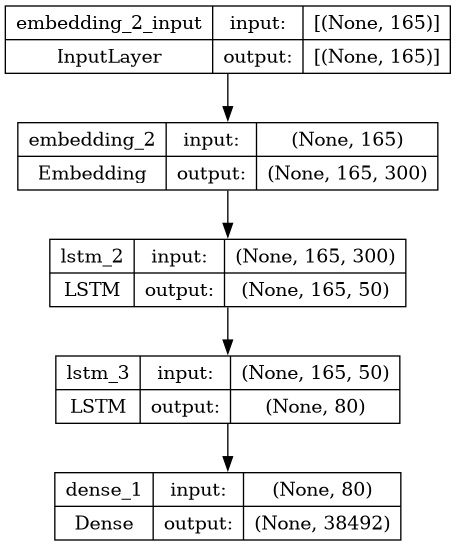

In [161]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [162]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [163]:
model.fit(X,y, epochs = 1, batch_size = 32)

39273/39273 [==============================] - 706s 18ms/step - loss: nan - accuracy: 0.0746


**Note: Increase no of epochs for better performance**

### Saving the model and Tokenizer : 
- In prediction time we can directly use these model and tokenizer we can predict.

In [174]:
# pickle
import pickle
from pickle import dump,load

model.save('Golve_pretrained_model.h5')
pickle.dump(tk, open('glove_tokenizer.pkl', 'wb'))

### loading model and tokernizer

In [175]:
from keras.models import load_model
model = load_model("/kaggle/working/Golve_pretrained_model.h5")

In [176]:
tokenizer = pickle.load(open("/kaggle/working/glove_tokenizer.pkl", 'rb'))

## Prediction

In [185]:
def predict_next_words(model, tk, text) :
    
    sequence = tokenizer.texts_to_sequences([text])
    pad_encoded = pad_sequences(sequence, maxlen=max_seq_len, truncating='pre')
    sequence = np.array(pad_encoded)
    
    preds = np.argmax(model.predict(sequence))
    predicted_word = ""
    #print(preds)
    
    for key, value in tk.word_index.items() :
        if value == preds :
            predicted_word = key
            break
    
    return predicted_word

In [186]:
l1 = ["this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills"]

l2 = ["imma is probably playing a bit of borderland tps. That will be fun."]

l3 = ["Come meet one of the beautiful gods of gambling."]

In [187]:
l = ["this was the first Borderlands", "imma is probably playing a bit of", "Come meet one of the beautiful gods of", "0"]

for i in l :
    
    text = i
    
    if text == "0" :
        print()
        print("Execution completed...")
        break
    
    else :
        try :
            text = text.split(" ")
            a = len(text)
            text = text[-a:]
            print("Input :", i)
            print("Output : ", i, predict_next_words(model, tk, text))
            print()
            
        except Exception as e :
            print("Error occured : ", e)
            continue

Input : this was the first Borderlands
1/1 [==============================] - 0s 23ms/step
Output :  this was the first Borderlands 

Input : imma is probably playing a bit of
1/1 [==============================] - 0s 23ms/step
Output :  imma is probably playing a bit of 

Input : Come meet one of the beautiful gods of
1/1 [==============================] - 0s 22ms/step
Output :  Come meet one of the beautiful gods of 


Execution completed...


## Another method : Prediction  On User Input

In [188]:
input_text = ["this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills"]
max_seq_len = 165

## Input preprocessing  step

In [189]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
    # convert in to string to overcome from float values
    review = str(review)
    #Normalizing the case 
    review = review.lower()
    #Removal of special characters
    review = re.sub(re_special_char,"", review)
    return review

## Prediction step

In [190]:
def pred_next_word(text, max_seq_len, tokenizer):
    text = text_preprocessing(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen = max_seq_len, padding = "pre")
    y_pred = model.predict(text, verbose = 0)
    best_word_pred = np.argmax(y_pred)
    return tokenizer.index_word[best_word_pred]

In [194]:
print("original_text :", input_text)
print("######################")
word = "this was the first Borderlands session in a long"
for i in range(15):
    word = word + " " + pred_next_word(word,max_seq_len, tokenizer)
print(word)